# Anderson localization of electromagnetic waves in three dimensions

**Note: This notebook contains large simulations. Running the entire notebook will cost about 30 FlexCredits.**

Anderson localization (AL) is an effect that is characterized by a halt of diffusive wave propagation. Despite extensive studies over the past 40 years, AL of the electromagnetic waves in three dimensions has remained elusive, leading to the question of its very existence. 

This notebook investigates the presence of AL in aggregates formed by a random placement of spheres made of either dielectric or perfect electric conductor (PEC). We use Tidy3D to simulate transmission of light through the aggregate arranged in the shape of a slab. From these simulations, we are able to identify for the first time, the hallmarks of Anderson localization in the PEC aggregate.

We study three specific case studies here:

1. The time and frequency dependence of transmission of light through a slab of randomly distributed dielectric spheres.
2. The time and frequency dependence of transmission of light through a slab of perfectly conducting (PEC) spheres.
3. The spatio-temporal dynamics of a beam being transmitted through this same slab.

These and related simulations were used to produce the results of our paper "Anderson localization of electromagnetic waves in three dimensions" by Yamilov, et al. For more details we refer the reader to this paper or its pre-preprint version, available [here](https://arxiv.org/abs/2203.02842).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import tidy3d as td
from tidy3d import web

td.config.logging_level = 'ERROR'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define our case study parameters

We now define some global parameters of the simulation, a datastructure to store our case study input parameters, and 3 specific instances of these parameters, which we will run at the end.

In [19]:
# parameters that are constant for all the simulations
wavelength = 0.65
freq0 = td.C_0 / wavelength
grids_pw = 20
npml = 2 * grids_pw
random_seed = 1

# Define grid spec
dl = wavelength / grids_pw
grid_spec = td.GridSpec.uniform(dl=dl)
    
# Define PML layers, for this we have no PML in x, y but `npml` cells in z
periodic_bc = td.Boundary(plus=td.Periodic(), minus=td.Periodic())
pml = td.Boundary(plus=td.Absorber(num_layers=npml), minus=td.Absorber(num_layers=npml))
boundary_spec = td.BoundarySpec(x=periodic_bc, y=periodic_bc, z=pml)

In [20]:
@dataclass
class SimulationParameters:
    """Stores parameters for a given simulation."""
    f0a : List[float]            # Array of frequencies to scan via FFT (in units of freq0)
    Lx : float                   # Length of slab in x
    Ly : float                   # Length of slab in y
    Lz : float                   # Length of slab in z
    space : float                # Space between PML and slab
    fwidth : float               # Bandwidth of the excitation pulse in Hz
    offset : float               # Gaussian source offset; the source peak is at time t = offset/fwidth
    run_time : float             # Run time of simulation (sec)
    ff0 : float                  # Nominal volume filling fraction, actual filling fraction is lower due to overlap between spheres
    radius : float               # Radius of spheres (um)
    material : str               # type of material to use for spheres. "dielectric" or "PEC"
    subpixel : bool              # Whether subpixel smoothening is used
    sim_mode : str               # Mode of simulation ("transmission" or "beam_spreading")
    task_name : str              # Name of the task in tidy3d
    ref_ind : float = None       # Refractive index of the spheres, needed if material == 'dielectric'    
    Nt: int = 1                  # Number of snapshots in the field time dependence monitor

In [21]:
# 1. Transmittance simulation (dielectric spheres)
sim_params_1 = SimulationParameters(
    Lx = 5 * wavelength,
    Ly = 5 * wavelength,
    Lz = 5 * wavelength,
    space = 2 * wavelength,
    radius = 0.1,
    ff0 = 0.35,
    fwidth = freq0 / 20.0,
    offset = 10.0,
    run_time = 8e-12,
    f0a = np.linspace(0.9, 1.1, 201).tolist(),
    material = "dielectric",
    ref_ind = 3.5,
    subpixel = True,
    sim_mode = "transmission",
    task_name = "dielectric_transmission",
)

In [22]:
# 2. Transmittance simulation (PEC spheres)
sim_params_2 = SimulationParameters(
    Lx = 6 * wavelength,
    Ly = 6 * wavelength,
    Lz = 2 * wavelength,
    space = 2 * wavelength,
    radius = 0.05,
    ff0 = 0.80,
    fwidth = freq0 / 7.0,
    offset = 10.0,
    run_time = 10e-12,
    f0a = np.linspace(0.8, 1.2, 201).tolist(),
    material = "PEC",
    ref_ind = None,
    subpixel = False,
    sim_mode = "transmission",
    task_name = "PEC_transmission",
)

In [23]:
# 3. Transverse spreading simulation (PEC spheres)
sim_params_3 = SimulationParameters(
    Lx = 20 * wavelength,
    Ly = 20 * wavelength,
    Lz = 2 * wavelength,
    space = 2 * wavelength,
    radius = 0.05,
    ff0 = 0.80,
    fwidth = freq0 / 7.0,
    offset = 10.0,
    run_time = 2e-12,
    Nt = 2,
    f0a = np.linspace(0.8, 1.2, 201).tolist(),
    material = "PEC",
    ref_ind = None,
    subpixel = False,
    sim_mode = "beam_spreading",
    task_name = "PEC_beam_spreading",
)

### Construct Simulation
Next, we write a few functions to generate a simulation based on our input parameters.

In [24]:
def get_mediums(sim_params: SimulationParameters) -> Tuple[td.Medium, td.Medium]:
    """Get the mediums corresponding to the spheres and the background, respectively."""

    if sim_params.material == "dielectric":
        if sim_params.ref_ind is None:
            raise ValueError("must specify SimulationParameters.ref_ind")            
        ff_appx = 1 - np.exp(-sim_params.ff0)
        medium_spheres = td.Medium(permittivity=sim_params.ref_ind**2)
        medium_out = td.Medium(permittivity=1 + (sim_params.ref_ind**2 - 1) * ff_appx)
    
    elif sim_params.material == "PEC":
        medium_spheres = td.PEC
        medium_out = td.Medium(permittivity=1)  

    else:
        raise ValueError(f"unrecognized 'material' of {sim_params.material}")

    return medium_spheres, medium_out        

In [25]:
# properties derived from sim_parameters
def make_sim(sim_params: SimulationParameters) -> td.Simulation:
    """Generate a simulation from given parameters."""

    medium_spheres, medium_out = get_mediums(sim_params)

    Lx = sim_params.Lx
    Ly = sim_params.Ly
    Lz = sim_params.Lz
    radius = sim_params.radius
    space = sim_params.space
    run_time = sim_params.run_time

    Lz_tot = 2 * space + Lz
    sim_size = [Lx, Ly, Lz_tot]

    # number of spheres to place = slab volume * nominal_density
    expanded_volume = (Lx + 2 * radius) * (Ly + 2 * radius) * (Lz + 2 * radius)
    nominal_density = sim_params.ff0 / (4 * np.pi / 3 * radius**3)
    num_spheres = int(expanded_volume * nominal_density)

    # Randomly position spheres
    np.random.seed(random_seed)
    sphere_geometries = []
    print(f"inserting {num_spheres:2e} spheres")
    for i in range(num_spheres):
        position_x = np.random.uniform(-Lx / 2 - radius, Lx / 2 + radius)
        position_y = np.random.uniform(-Ly / 2 - radius, Ly / 2 + radius)
        position_z = np.random.uniform(-Lz / 2 - radius, Lz / 2 + radius)
        sphere_i = td.Sphere(
            center=[position_x, position_y, position_z],
            radius=radius
        )
        sphere_geometries.append(sphere_i)
    
    spheres = td.Structure(
        geometry=td.GeometryGroup(geometries=sphere_geometries),
        medium=medium_spheres
    )

    # Define effective medium around the slab
    box_in = td.Box(center=[0, 0, -Lz / 2 - space], size=[td.inf, td.inf, 2 * space])
    box_out = td.Box(center=[0, 0, Lz / 2 + space], size=[td.inf, td.inf, 2 * space])
    struct_in = td.Structure(geometry=box_in, medium=medium_out)
    struct_out = td.Structure(geometry=box_out, medium=medium_out)

    structures = [spheres, struct_in, struct_out]

    # Define incident plane wave
    gaussian = td.GaussianPulse(
        freq0=freq0,
        fwidth=sim_params.fwidth,
        offset=sim_params.offset,
        phase=0
    )
    
    if sim_params.sim_mode == "transmission":
        source_size = (td.inf, td.inf, 0)
    elif sim_params.sim_mode == "beam_spreading":
        source_size = (0.25, 0.25, 0.0)
    else:
        raise ValueError(f"sim_mode of {sim_params.sim_mode} not recognized.")

    # angle of polarization w.r.t. to the x axis (x-polarized)
    source = td.PlaneWave(
        size=source_size,
        center=(0, 0, -Lz_tot / 2.0 + 0.1),
        source_time=gaussian,
        direction="+",
        pol_angle=0,
    )

    freqs_fft = (freq0 * np.array(sim_params.f0a)).tolist()

    # Records CW (via FFT) transmitted flux through the slab
    freq_monitorT = td.FluxMonitor(
        center=[0.0, 0.0, Lz / 2.0 + space / 2.0],
        size=[td.inf, td.inf, 0],
        freqs=freqs_fft,
        name="freq_monitorT",
    )

    # Records time-dependent transmitted flux through the slab
    time_monitorT = td.FluxTimeMonitor(
        center=[0.0, 0.0, Lz / 2.0 + space / 2.0],
        size=[td.inf, td.inf, 0],
        name="time_monitorT",
    )

    # Records E-fields throughout simulation volume at t=run_time/2
    time_monitorZH = td.FieldTimeMonitor(
        center=[0.0, 0.0, 0.0],
        size=[td.inf, td.inf, Lz + wavelength],
        start=run_time / 2.0,
        stop=run_time / 2.0,
        fields=["Ex", "Ey", "Ez"],
        name="time_monitorZH",
    )

    # Records E-fields throughout simulation volume at t=run_time
    time_monitorZ = td.FieldTimeMonitor(
        center=[0.0, 0.0, 0.0],
        size=[td.inf, td.inf, Lz + wavelength],
        start=run_time,
        stop=run_time,
        fields=["Ex", "Ey", "Ez"],
        name="time_monitorZ",
    )

    N_run_time = int(sim_params.run_time / (0.99 * wavelength / (grids_pw * td.C_0 * np.sqrt(3))))

    # Records E-fields at the output surface at Nt equally spaced times from 0 to run_time
    spread_monitor = td.FieldTimeMonitor(
        center=[0.0, 0.0, Lz / 2.0 + 2 * wavelength / grids_pw],
        size=[td.inf, td.inf, 0.0],
        start=0.4 * run_time,
        stop=0.9 * run_time,
        interval=int(N_run_time / sim_params.Nt),
        fields=["Ex", "Ey", "Ez"],
        name="spread_monitor",
    )
    
    # Records permittivity throughout simulation volume
    eps_monitor = td.PermittivityMonitor(
        center=[0.0, 0.0, 0.0],
        size=[td.inf, td.inf, Lz + wavelength],
        freqs=[freq0],
        name="eps_monitor",
    )

    monitors = [freq_monitorT, time_monitorT, eps_monitor]
    
    if sim_params.sim_mode == "transmission":
        monitors.append(time_monitorZH)
        monitors.append(time_monitorZ)
    elif sim_params.sim_mode == "beam_spreading":
        monitors.append(spread_monitor)
    else:
        raise ValueError(f"sim_mode of {sim_params.sim_mode} not recognized.")

    # Define simulation parameters     
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=structures,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=boundary_spec,
        shutoff=1e-15,
        subpixel=sim_params.subpixel,
    )

    return sim


### Post process data

Next, we write some functions to process the simulation data from tidy3d into a datastructure storing the output quantities of interest.

In [26]:
@dataclass
class SimulationOutputs:
    """Stores outputs of a given simulation."""
    flux_f : td.FluxDataArray                        # Flux transmission as a function of frequency
    flux_t : td.FluxTimeDataArray                    # Flux transmission as a function of time
    eps : td.ScalarFieldDataArray                    # Relative permattivity at the Ex positions in the yee lattice
    ff_realized : float                              # Sphere filling fraction as computed from the raw permittivity distribution
    int_half : td.ScalarFieldTimeDataArray = None    # Field intensity at the time halfway through simulation
    int_end : td.ScalarFieldTimeDataArray = None     # Field intensity at the final time in simulation
    int_spread : td.ScalarFieldTimeDataArray = None  # Fiend intensity cross section as function of time

In [27]:
def compute_ff(sim_params: SimulationParameters, eps: td.ScalarFieldDataArray) -> float:
    """Compute effective filling fraction from data."""
    Lz = sim_params.Lz
    eps_in_slab = np.real(eps)
    eps_in_slab = eps_in_slab.where(eps_in_slab.z < Lz/2, drop=True)
    eps_in_slab = eps_in_slab.where(eps_in_slab.z > -Lz/2, drop=True)
    
    if sim_params.material == "dielectric":
        eps_max = sim_params.ref_ind**2
        ff = (np.mean(eps_in_slab.values) - 1) / (eps_max - 1)
    elif sim_params.material == "PEC":
        is_material = 1.0 * (eps_in_slab.values != 1.0)
        ff = np.mean(is_material)
    else:
        raise ValueError(f"unrecognized 'material' of {sim_params.material}")
    return ff

In [28]:
def post_process_results(sim_params: SimulationParameters, sim_data: td.SimulationData) -> SimulationOutputs:
    """Process the results of a simulation run into SimulationOutputs."""

    flux_f = sim_data["freq_monitorT"].flux
    flux_t = sim_data["time_monitorT"].flux
    eps = sim_data["eps_monitor"].eps_xx
    ff_realized = compute_ff(sim_params, eps)
    
    if sim_params.sim_mode == "transmission":
        int_half = sim_data.get_intensity("time_monitorZH")
        int_end = sim_data.get_intensity("time_monitorZ")
        sim_outputs = SimulationOutputs(
            flux_f = sim_data["freq_monitorT"].flux,
            flux_t = sim_data["time_monitorT"].flux,
            int_half = sim_data.get_intensity("time_monitorZH"),
            int_end = sim_data.get_intensity("time_monitorZ"),
            eps = sim_data["eps_monitor"].eps_xx,
            ff_realized = ff_realized,
        )    

    elif sim_params.sim_mode == "beam_spreading":
        int_spread = sim_data.get_intensity("spread_monitor")
        sim_outputs = SimulationOutputs(
            flux_f = sim_data["freq_monitorT"].flux,
            flux_t = sim_data["time_monitorT"].flux,
            eps = sim_data["eps_monitor"].eps_xx,
            ff_realized = ff_realized,
            int_spread = int_spread,
        )
    else:
        raise ValueError(f"sim_mode of {sim_mode} not recognized.")
    
    return sim_outputs

### Run FDTD simulation

Next, we write a function to compute our simulation outputs given simulation parameters through a tidy3d simulation.

In [29]:
def run(sim_params : SimulationParameters) -> SimulationOutputs:
    """process simulation parameters into simulation outputs through a tidy3d simulation."""
    sim = make_sim(sim_params)
    sim_data = web.run(sim, task_name=sim_params.task_name)
    return post_process_results(sim_params, sim_data)

### Visualization

Next, we write a function to visualize the simulation outputs depending on the data contained within.

In [30]:
def plot_transmission(sim_params: SimulationParameters, sim_outputs: SimulationOutputs) -> None:

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True)
    
    sim_outputs.flux_f.plot(ax=ax1)
    sim_outputs.flux_t.plot(ax=ax2)

    def take_log(intensity):
        return np.log10(intensity / intensity.max() + 1e-6)
    
    if sim_outputs.int_half is not None:
        # Intensity section I(0,y,z;tmax/2)
        take_log(sim_outputs.int_half).interp(x=0).squeeze().plot.pcolormesh(ax=ax3)
        take_log(sim_outputs.int_end).interp(x=0).squeeze().plot.pcolormesh(ax=ax4)
        ax2.set_yscale("log")
        ax3.set_aspect(1)
        ax4.set_aspect(1)
    elif sim_outputs.int_spread is not None:
        # Intensity section I(x,y,L;t)
        np.log10(sim_outputs.int_spread).isel(t=0).squeeze().plot.pcolormesh(ax=ax3)
        np.log10(sim_outputs.int_spread).isel(t=-1).squeeze().plot.pcolormesh(ax=ax4)
        ax2.set_yscale("log")
        ax3.set_aspect(1)
        ax4.set_aspect(1)        
    plt.show()

### Combined Workflow

Finally, we'll combine all the previous steps into a single function to process and visualize a set of simulation parameters.

In [31]:
def workflow(sim_params: SimulationParameters) -> SimulationOutputs:
    """Run the simulation, plot results, and compute fill fraction."""

    # run the simulation
    sim_outputs = run(sim_params)

    # display the fill fraction
    print(f"ff_realized = {(sim_outputs.ff_realized*100):.2f} %") 

    # plot data
    plot_transmission(sim_params, sim_outputs)
    
    # plot the simulation
    sim = make_sim(sim_params)
    f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
    sim.plot(x=0, monitor_alpha=0, ax=ax1)
    sim.plot(z=0, monitor_alpha=0, ax=ax2)
    plt.show()    

    return sim_outputs

## Case Studies

Now we are ready to put everything together to run our three case studies.

### Dielectric Sphere Transmission

First, we simulate a pulse transmission through a slab containing randomly distributed dielectric spheres. It shows that transmited flux decays mono-exponentially with time, as expected for diffusive transport. y-z cross-sections of the spatial intensity distribution, obtained at long times show sine-like dependence with the depth coordinate z, also expected in diffusion. We also show y-z and x-y slices of dielectric permeability of the simulated system for illustration.

inserting 3.431000e+03 spheres


Output()

Output()

Output()

Output()

Output()

ff_realized = 27.67 %


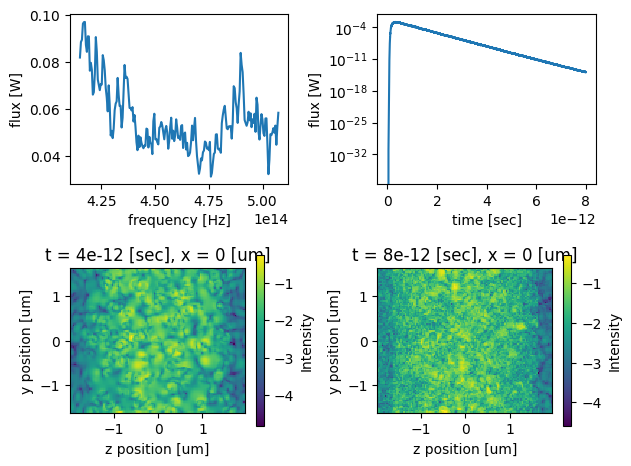

inserting 3.431000e+03 spheres


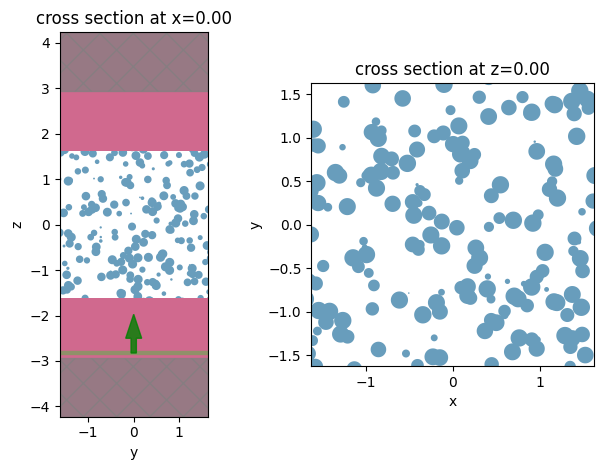

In [15]:
sim_outputs_1 = workflow(sim_params_1)


### PEC Transmission

Next we simulate a pulse transmission through a slab containing randomly distributed PEC spheres. It shows that transmitted flux decays non-exponentially with time, as predicted for AL. y-z cross-sections of the spatial intensity distribution, obtained at long times show confined (i.e. localized) states. We also show y-z and x-y slices of dielectric permeability of the simulated system for illustration.

inserting 3.422400e+04 spheres


Output()

Output()

Output()

Output()

Output()

ff_realized = 46.90 %


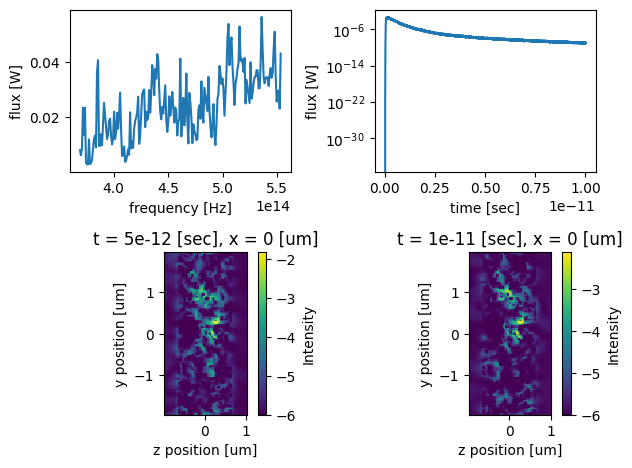

inserting 3.422400e+04 spheres


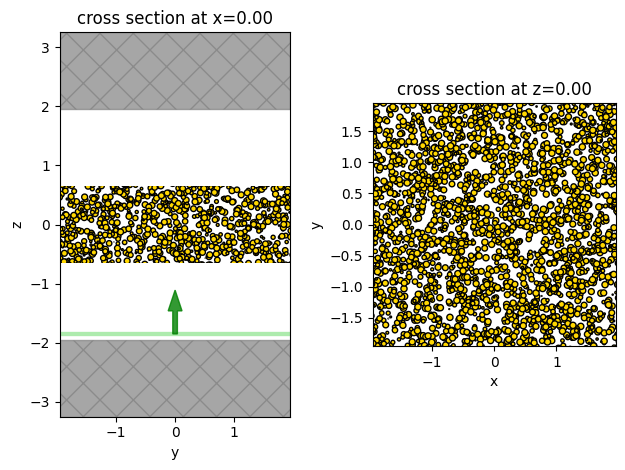

In [16]:
sim_outputs_2 = workflow(sim_params_2)


### PEC Beam Spreading

Finally, we simulate transverse beam spreading at the output surface of a slab containing PEC spheres. It shows that transmittance flux decays mono-exponentially with time, as expected for diffusive transport. Spatial x-y intensity distributions at the output surface, obtained at long times show that the beam waist does not increase with time. We also show y-z and x-y slices of dielectric permeability of the simulated system for illustration.

inserting 3.670810e+05 spheres


Output()

Output()

Output()

Output()

Output()

ff_realized = 46.95 %


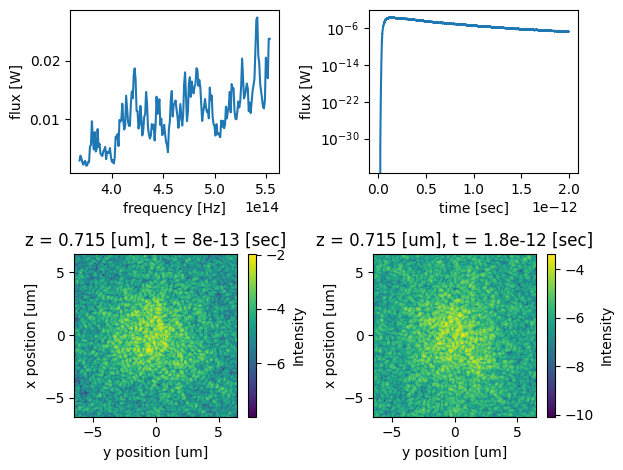

inserting 3.670810e+05 spheres


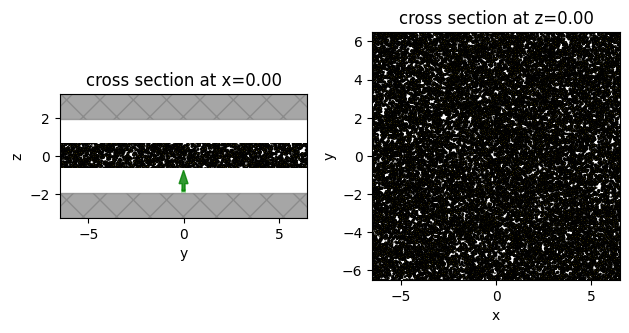

In [32]:
sim_outputs_3 = workflow(sim_params_3)
